# Synthetic Experiment Validation

Run the degeneracy detector on four synthetic datasets with **known** relationships.
Each experiment verifies that the pipeline correctly identifies the degenerate groups
and recovers the planted equation.

In [11]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, '/anvil/scratch/x-ctirapongpra/degeneracy_detector/')

from degen_detector import DegenDetector
from degen_detector.synthetic import (
    generate_linear_degeneracy,
    generate_power_law_degeneracy,
    generate_multigroup_degeneracy,
    generate_three_param_degeneracy,
)

%matplotlib inline
plt.rcParams.update({'font.size': 16, 'figure.figsize': (12, 8)})

---
## Experiment 1: Linear degeneracy

**Ground truth:** y = 2x + 1, z independent  
**Expected:** one group {x, y}, z excluded

In [2]:
samples_1, names_1 = generate_linear_degeneracy(n=2000, noise=0.01)
det_1 = DegenDetector(samples_1, names_1)
res_1 = det_1.analyze_multi(niterations=40, max_complexity=15)

print(f'Groups: {len(res_1.grouping.groups)}')
for g in res_1.grouping.groups:
    print(f'  {g.param_names}  avg_MI={g.avg_mi:.3f}  constraints={g.n_constraints}')
print()
for d in res_1.multi_degeneracies:
    print(f'  {d.fit.equation_str}   R²={d.fit.r_squared:.4f}')

Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 4.660e+04
Progress: 279 / 600 total iterations (46.500%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.004e+00  0.000e+00  target = -0.05533
3           2.089e-01  7.848e-01  target = y * 0.40741
5           2.482e-05  4.519e+00  target = (y * 0.49997) + -0.50006
11          2.480e-05  9.876e-05  target = ((y + -1.0002) * (1.0829e-05 + y)) * (0.4999...
                                           7 / y)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.510e+04
Progress: 538 / 600 total iterations (89.667%)
═══

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20260202_195215_SKhN2m/hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 3.480e+04
Progress: 206 / 600 total iterations (34.333%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.897e+00  0.000e+00  y = x
3           9.974e-01  3.214e-01  y = x * 1.9453
5           9.928e-05  4.608e+00  y = (x * 2.0001) + 1.0002
9           9.926e-05  3.653e-05  y = x + ((x + 1.0001) * (1.0001 ^ x))
11          9.926e-05  1.431e-06  y = ((x * 2.0001) + 1.0001) + (x * (x * 8.5768e-05))
13          9.926e-05  2.682e-07  y = ((x + (x * (x * 8.5746e-05))) + (x * 1.0001)) + 1.0001
14          9.920e-05  5.999e-04  y = (exp(((x / (x - -0.10415)) / x) * -2.6042e-06) + x) + ...
                                      x
───────────────────────────────────────────────────────────────────────────────────────────────────
═══════════════════════════

[ Info: Final population:
[ Info: Results saved to:


Groups: 1
  ['x', 'y']  avg_MI=5.137  constraints=1

  x = (y * 0.49997443) + -0.500058   R²=1.0000
  - outputs/20260202_195236_UeN0AM/hall_of_fame.csv


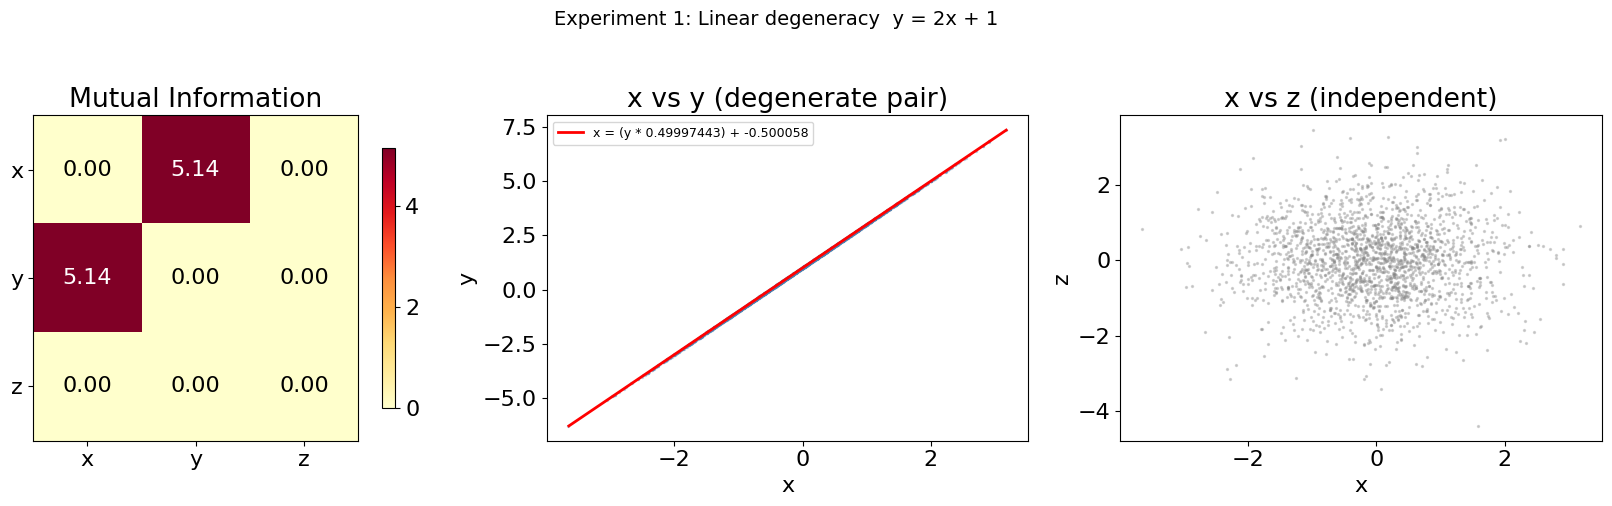

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# MI heatmap
ax = axes[0]
mi = res_1.grouping.mi_result.mi_matrix
im = ax.imshow(mi, cmap='YlOrRd')
ax.set_xticks(range(len(names_1))); ax.set_yticks(range(len(names_1)))
ax.set_xticklabels(names_1); ax.set_yticklabels(names_1)
for i in range(len(names_1)):
    for j in range(len(names_1)):
        ax.text(j, i, f'{mi[i,j]:.2f}', ha='center', va='center',
                color='white' if mi[i,j] > mi.max()/2 else 'black')
plt.colorbar(im, ax=ax, shrink=0.8)
ax.set_title('Mutual Information')

# Scatter with fit
ax = axes[1]
ax.scatter(samples_1[:, 0], samples_1[:, 1], s=2, alpha=0.3, c='steelblue')
if res_1.multi_degeneracies:
    fit = res_1.multi_degeneracies[0].fit
    input_idx = [names_1.index(n) for n in fit.input_names]
    X_in = samples_1[:, input_idx]
    y_pred = fit.predict(X_in)
    target_idx = names_1.index(fit.target_name)
    sort = np.argsort(X_in[:, 0])
    if fit.target_name == 'y':
        ax.plot(X_in[sort, 0], y_pred[sort], 'r-', lw=2, label=fit.equation_str)
    else:
        ax.plot(y_pred[sort], samples_1[sort, 1], 'r-', lw=2, label=fit.equation_str)
    ax.legend(fontsize=9)
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('x vs y (degenerate pair)')

# x vs z (should be independent)
ax = axes[2]
ax.scatter(samples_1[:, 0], samples_1[:, 2], s=2, alpha=0.3, c='gray')
ax.set_xlabel('x'); ax.set_ylabel('z')
ax.set_title('x vs z (independent)')

fig.suptitle('Experiment 1: Linear degeneracy  y = 2x + 1', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

---
## Experiment 2: Power-law degeneracy

**Ground truth:** σ₈ = 0.83 / Ωm^0.5, ns independent  
**Expected:** one group {Om, sigma8}, ns excluded

In [4]:
samples_2, names_2 = generate_power_law_degeneracy(n=2000, noise=0.01)
det_2 = DegenDetector(samples_2, names_2)
res_2 = det_2.analyze_multi(niterations=40, max_complexity=15)

print(f'Groups: {len(res_2.grouping.groups)}')
for g in res_2.grouping.groups:
    print(f'  {g.param_names}  avg_MI={g.avg_mi:.3f}  constraints={g.n_constraints}')
print()
for d in res_2.multi_degeneracies:
    print(f'  {d.fit.equation_str}   R²={d.fit.r_squared:.4f}')

[ Info: Started!



Expressions evaluated per second: 2.590e+04
Progress: 160 / 600 total iterations (26.667%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.373e-03  0.000e+00  y = 0.30057
3           5.233e-04  9.316e-01  y = 0.4556 ^ sigma8
4           1.887e-04  1.020e+00  y = 1.3894 / exp(sigma8)
5           2.559e-05  1.998e+00  y = 2.2928 / (3.7949 ^ sigma8)
6           2.202e-05  1.499e-01  y = 2.1896 / exp(sigma8 * 1.3055)
7           1.766e-05  2.210e-01  y = ((0.72644 ^ sigma8) / sigma8) ^ 1.334
9           1.760e-05  1.703e-03  y = (sigma8 + (497.11 / sigma8)) / (sigma8 * 724.81)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20260202_195306_Ey6JPj/hall_of_fame.csv

Expressions evaluated per second: 2.680e+04
Progress: 159 / 600 total iterations (26.500%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.375e-02  0.000e+00  y = 1.5364
3           9.414e-03  4.627e-01  y = 1.837 - Om
4           9.898e-05  4.555e+00  y = sqrt(0.68907 / Om)
5           9.897e-05  7.212e-05  y = (0.68965 / Om) ^ 0.49947
6           9.896e-05  7.314e-05  y = (0.82945 / sqrt(Om)) + 0.0012112
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.


[ Info: Started!



Expressions evaluated per second: 2.870e+04
Progress: 335 / 600 total iterations (55.833%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.375e-02  0.000e+00  y = 1.5364
3           2.150e-03  1.201e+00  y = Om ^ -0.35502
4           9.898e-05  3.078e+00  y = 0.8301 / sqrt(Om)
5           9.896e-05  1.537e-04  y = (0.68959 / Om) ^ 0.49958
9           9.896e-05  1.490e-08  y = (((0.68959 / Om) ^ 0.49958) + Om) - Om
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.290e+04
Progress: 411 / 600 total iterations (68.500%)
══════════════════════════

[ Info: Final population:
[ Info: Results saved to:


Groups: 1
  ['Om', 'sigma8']  avg_MI=2.573  constraints=1

  sigma8 = 0.8301044 / sqrt(Om)   R²=0.9958
  - outputs/20260202_195331_3TwqqO/hall_of_fame.csv


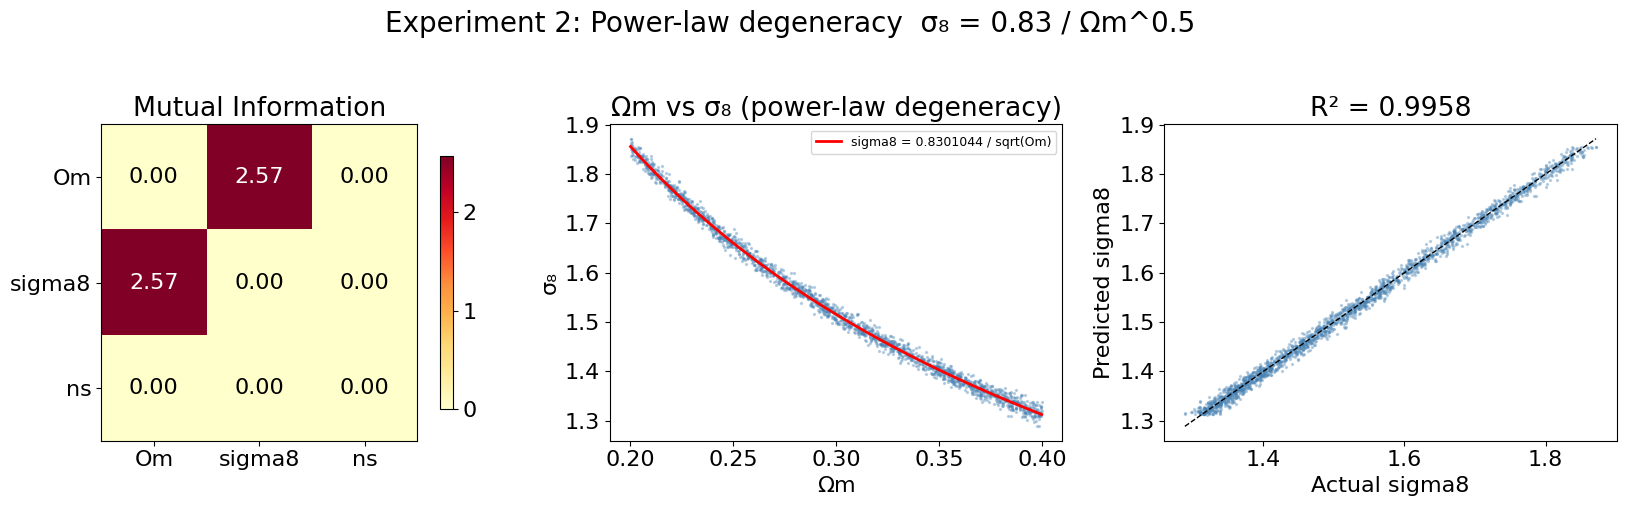

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# MI heatmap
ax = axes[0]
mi = res_2.grouping.mi_result.mi_matrix
im = ax.imshow(mi, cmap='YlOrRd')
ax.set_xticks(range(len(names_2))); ax.set_yticks(range(len(names_2)))
ax.set_xticklabels(names_2); ax.set_yticklabels(names_2)
for i in range(len(names_2)):
    for j in range(len(names_2)):
        ax.text(j, i, f'{mi[i,j]:.2f}', ha='center', va='center',
                color='white' if mi[i,j] > mi.max()/2 else 'black')
plt.colorbar(im, ax=ax, shrink=0.8)
ax.set_title('Mutual Information')

# Scatter with fit
ax = axes[1]
ax.scatter(samples_2[:, 0], samples_2[:, 1], s=2, alpha=0.3, c='steelblue')
if res_2.multi_degeneracies:
    fit = res_2.multi_degeneracies[0].fit
    # Plot the discovered curve
    Om_sorted = np.sort(samples_2[:, 0])
    X_plot = Om_sorted.reshape(-1, 1)
    if fit.target_name == 'sigma8':
        ax.plot(Om_sorted, fit.predict(X_plot), 'r-', lw=2, label=fit.equation_str)
    else:
        s8_sorted = np.sort(samples_2[:, 1])
        ax.plot(fit.predict(s8_sorted.reshape(-1, 1)), s8_sorted, 'r-', lw=2,
                label=fit.equation_str)
    ax.legend(fontsize=9)
ax.set_xlabel('Ωm'); ax.set_ylabel('σ₈')
ax.set_title('Ωm vs σ₈ (power-law degeneracy)')

# Predicted vs actual
ax = axes[2]
if res_2.multi_degeneracies:
    fit = res_2.multi_degeneracies[0].fit
    input_idx = [names_2.index(n) for n in fit.input_names]
    target_idx = names_2.index(fit.target_name)
    y_actual = samples_2[:, target_idx]
    y_pred = fit.predict(samples_2[:, input_idx])
    ax.scatter(y_actual, y_pred, s=2, alpha=0.3, c='steelblue')
    lims = [min(y_actual.min(), y_pred.min()), max(y_actual.max(), y_pred.max())]
    ax.plot(lims, lims, 'k--', lw=1)
    ax.set_xlabel(f'Actual {fit.target_name}')
    ax.set_ylabel(f'Predicted {fit.target_name}')
    ax.set_title(f'R² = {fit.r_squared:.4f}')

fig.suptitle('Experiment 2: Power-law degeneracy  σ₈ = 0.83 / Ωm^0.5', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

---
## Experiment 3: Multiple groups

**Ground truth:** b = 3a − 2 (group 1), d = exp(c) (group 2), e independent  
**Expected:** two separate groups {a, b} and {c, d}, e excluded

In [6]:
samples_3, names_3 = generate_multigroup_degeneracy(n=2000, noise=0.01)
det_3 = DegenDetector(samples_3, names_3)
res_3 = det_3.analyze_multi(niterations=40, max_complexity=15)

print(f'Groups: {len(res_3.grouping.groups)}')
for g in res_3.grouping.groups:
    print(f'  {g.param_names}  avg_MI={g.avg_mi:.3f}  constraints={g.n_constraints}')
print()
for d in res_3.multi_degeneracies:
    print(f'  {d.fit.equation_str}   R²={d.fit.r_squared:.4f}')

[ Info: Started!



Expressions evaluated per second: 4.780e+04
Progress: 275 / 600 total iterations (45.833%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.004e+00  0.000e+00  y = -0.05513
3           2.925e-01  6.164e-01  y = b / 4.3835
5           1.103e-05  5.093e+00  y = (b - -1.9998) * 0.33332
7           1.103e-05  1.758e-06  y = ((b * 1.3333) - b) - -0.66659
9           1.103e-05  3.636e-06  y = (((-0.28568 - b) * -2.3333) - b) - b
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.800e+04
Progress: 525 / 600 total iterations (87.500%)
══════════════════

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20260202_195356_7kIo3W/hall_of_fame.csv

Expressions evaluated per second: 4.830e+04
Progress: 273 / 600 total iterations (45.500%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.467e+00  0.000e+00  y = a
3           3.987e+00  3.765e-01  y = a * 3.1095
4           3.652e+00  8.795e-02  y = exp(a) - 3.6612
5           9.928e-05  1.051e+01  y = (a * 3) + -1.9998
7           9.928e-05  2.980e-07  y = ((a * 1.4372) - 0.95803) * 2.0875
9           9.926e-05  7.386e-05  y = (((a * 8.5756e-05) + 3.0001) * a) - 1.9999
10          9.924e-05  2.129e-04  y = (0.00012813 / exp(a)) + ((a * 3.0003) - 2.0001)
12          9.923e-05  3.684e-05  y = ((a * 3.0002) - 1.9999) + ((a * -4.2327e-05) / exp(a))
13          9.891e-05  3.287e-03  y = (a * 3.0001) - (((a / (a - 0.12056)) * -9.9

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


  - outputs/20260202_195408_DxIyHQ/hall_of_fame.csv

Expressions evaluated per second: 1.550e+04
Progress: 107 / 600 total iterations (17.833%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.285e-01  0.000e+00  y = -0.027176
2           1.895e-04  7.458e+00  y = log(d)
4           1.884e-04  2.862e-03  y = log(d + 0.00075998)
6           1.876e-04  2.126e-03  y = log(d + 0.0019709) - 0.0019015
10          1.868e-04  1.105e-03  y = ((d - 0.0014705) * (d ^ -0.99912)) * log(d)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.


[ Info: Started!



Expressions evaluated per second: 1.770e+04
Progress: 213 / 600 total iterations (35.500%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.285e-01  0.000e+00  y = -0.027176
2           1.895e-04  7.458e+00  y = log(d)
4           1.884e-04  2.862e-03  y = log(d + 0.00075998)
6           1.876e-04  2.126e-03  y = log(d + 0.0019709) - 0.0019015
8           1.872e-04  1.237e-03  y = log(d + ((0.0013103 / d) ^ 1.1038))
9           1.868e-04  1.883e-03  y = log(d + (0.0013103 / (d * exp(d))))
10          1.849e-04  1.013e-02  y = log(((d * d) - -0.0050827) * 0.99182) * 0.50297
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q'

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20260202_195418_AOoNYW/hall_of_fame.csv

Expressions evaluated per second: 2.470e+04
Progress: 156 / 600 total iterations (26.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.137e-01  0.000e+00  y = 1.1424
2           1.000e-04  8.328e+00  y = exp(c)
4           9.997e-05  1.975e-04  y = sqrt(7.3924 ^ c)
5           9.990e-05  7.284e-04  y = (2.7192 ^ c) - 0.00029171
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.570e+04
Progress: 310 / 600 total iterations (51.667%)
══════════════════════════════════════════════════════════

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 2.370e+04
Progress: 574 / 600 total iterations (95.667%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.137e-01  0.000e+00  y = 1.1424
2           1.000e-04  8.328e+00  y = exp(c)
3           9.997e-05  3.948e-04  y = 2.7189 ^ c
4           9.997e-05  2.384e-07  y = sqrt(7.3924 ^ c)
5           9.989e-05  7.616e-04  y = (2.72 ^ c) * 0.99966
8           9.976e-05  4.277e-04  y = (0.00015246 / (-1.0514 - c)) + exp(c)
10          9.974e-05  1.229e-04  y = (0.00015246 / (-1.0514 - c)) + (exp(c) ^ 1.0002)
12          9.957e-05  8.653e-04  y = exp(c / 1.0002) + (0.00015246 / ((1.0377 / c) - c))
───────────────────────────────────────────────────────────────────────────────────────────────────
══════════════════════════════════════════════════════════

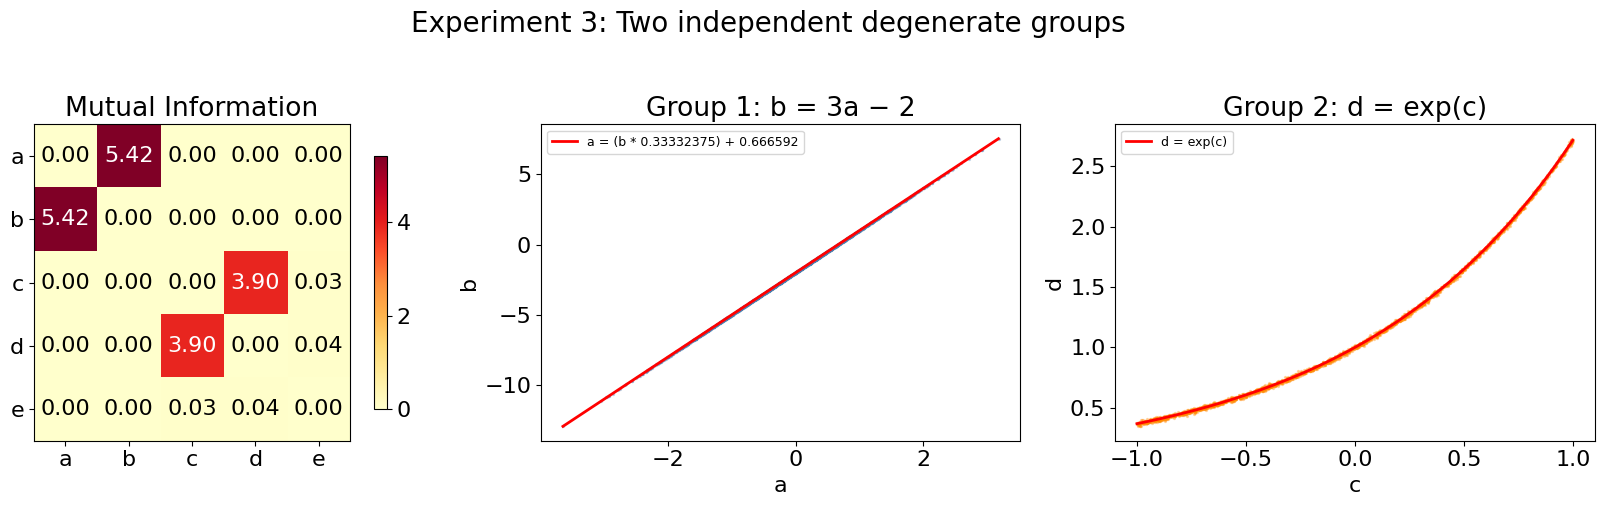

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# MI heatmap
ax = axes[0]
mi = res_3.grouping.mi_result.mi_matrix
im = ax.imshow(mi, cmap='YlOrRd')
ax.set_xticks(range(len(names_3))); ax.set_yticks(range(len(names_3)))
ax.set_xticklabels(names_3); ax.set_yticklabels(names_3)
for i in range(len(names_3)):
    for j in range(len(names_3)):
        ax.text(j, i, f'{mi[i,j]:.2f}', ha='center', va='center',
                color='white' if mi[i,j] > mi.max()/2 else 'black')
plt.colorbar(im, ax=ax, shrink=0.8)
ax.set_title('Mutual Information')

# Group 1: a vs b
ax = axes[1]
ax.scatter(samples_3[:, 0], samples_3[:, 1], s=2, alpha=0.3, c='steelblue')
# Find the fit for group {a, b}
for d in res_3.multi_degeneracies:
    if set(d.param_names) == {'a', 'b'}:
        fit = d.fit
        input_idx = [names_3.index(n) for n in fit.input_names]
        X_in = samples_3[:, input_idx]
        sort = np.argsort(X_in[:, 0])
        if fit.target_name == 'b':
            ax.plot(X_in[sort, 0], fit.predict(X_in[sort]), 'r-', lw=2,
                    label=fit.equation_str)
        else:
            ax.plot(fit.predict(X_in[sort]), samples_3[sort, 1], 'r-', lw=2,
                    label=fit.equation_str)
        ax.legend(fontsize=9)
        break
ax.set_xlabel('a'); ax.set_ylabel('b')
ax.set_title('Group 1: b = 3a − 2')

# Group 2: c vs d
ax = axes[2]
ax.scatter(samples_3[:, 2], samples_3[:, 3], s=2, alpha=0.3, c='darkorange')
for d in res_3.multi_degeneracies:
    if set(d.param_names) == {'c', 'd'}:
        fit = d.fit
        input_idx = [names_3.index(n) for n in fit.input_names]
        X_in = samples_3[:, input_idx]
        sort = np.argsort(X_in[:, 0])
        if fit.target_name == 'd':
            ax.plot(X_in[sort, 0], fit.predict(X_in[sort]), 'r-', lw=2,
                    label=fit.equation_str)
        else:
            ax.plot(fit.predict(X_in[sort]), samples_3[sort, 3], 'r-', lw=2,
                    label=fit.equation_str)
        ax.legend(fontsize=9)
        break
ax.set_xlabel('c'); ax.set_ylabel('d')
ax.set_title('Group 2: d = exp(c)')

fig.suptitle('Experiment 3: Two independent degenerate groups', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

---
## Experiment 4: Three-parameter degeneracy

**Ground truth:** z = x² + y  
**Expected:** one group {x, y, z}, multi-input regression z = f(x, y)

In [8]:
samples_4, names_4 = generate_three_param_degeneracy(n=2000, noise=0.01)
det_4 = DegenDetector(samples_4, names_4)
res_4 = det_4.analyze_multi(niterations=40, max_complexity=15)

print(f'Groups: {len(res_4.grouping.groups)}')
for g in res_4.grouping.groups:
    print(f'  {g.param_names}  avg_MI={g.avg_mi:.3f}  constraints={g.n_constraints}')
print()
for d in res_4.multi_degeneracies:
    print(f'  {d.fit.equation_str}   R²={d.fit.r_squared:.4f}')

[ Info: Started!



Expressions evaluated per second: 4.610e+04
Progress: 258 / 600 total iterations (43.000%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.349e+00  0.000e+00  target = 0.011355
3           1.348e+00  2.921e-04  target = 0.0016951 / y
4           1.348e+00  5.788e-05  target = exp(z) * 0.00081618
5           1.347e+00  1.223e-03  target = 0.00058197 / (y - 1.3872)
6           1.345e+00  1.209e-03  target = (exp(z) / y) * 0.0004067
8           1.344e+00  2.983e-04  target = (6.6028e-05 / y) * exp(z / 0.65279)
9           1.344e+00  6.795e-06  target = 6.6028e-05 * (exp(z / exp(-0.45261)) / y)
10          1.344e+00  1.406e-04  target = (exp(z * 1.7227) * (-4.7978 / y)) * -6.994e-...
                                           06
14          1.344e+00  4.453e-05  target = ((z * exp(z

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20260202_195506_eAZAhr/hall_of_fame.csv

Expressions evaluated per second: 3.800e+04
Progress: 208 / 600 total iterations (34.667%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.344e+00  0.000e+00  y = -0.027112
3           9.638e-01  1.661e-01  y = z * 0.29075
5           6.869e-01  1.693e-01  y = (1.3778 - z) * -0.48828
7           1.001e-04  4.417e+00  y = (z - (x * x)) * 0.99965
9           1.001e-04  1.053e-04  y = ((x * x) * -0.99973) - (z * -0.99965)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.160e+04
Progress: 483 / 

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.344e+00  0.000e+00  y = -0.027112
3           9.638e-01  1.661e-01  y = z * 0.29075
5           1.003e-04  4.585e+00  y = z - (x * x)
7           1.001e-04  8.263e-04  y = (z - (x * x)) * 0.99965
9           9.996e-05  7.256e-04  y = (z - (x * x)) + (-1.2277e-05 / x)
11          9.993e-05  1.715e-04  y = z - ((x * x) + (-1.2277e-05 / (-0.77075 * x)))
13          9.992e-05  3.499e-05  y = z - ((1.092e-06 / (x - (x * 0.94509))) + (x * x))
15          9.965e-05  1.372e-03  y = z - (((-0.12288 / ((x - 1.1384) * x)) * 0.0001473) + (...
                                      x * x))
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20260202_195518_8lg3aH/hall_of_fame.csv


[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 3.200e+04
Progress: 200 / 600 total iterations (33.333%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.754e+00  0.000e+00  target = 1.3223
2           2.575e+00  6.726e-02  target = exp(y)
3           1.345e+00  6.493e-01  target = x * x
5           1.003e-04  4.752e+00  target = y + (x * x)
7           1.002e-04  5.104e-04  target = (x * x) + (y / 0.99974)
9           1.001e-04  1.028e-04  target = ((x * 1.0001) * x) + (y / 0.99974)
11          1.001e-04  2.131e-05  target = (x * ((x * 1.0001) + 4.9385e-05)) + (y / 0.9...
                                           9973)
12          1.000e-04  1.262e-03  target = (x * x) + (y + (5.0409e-05 * exp(y + y)))
──────────────────────────────────────────────────────────────────────────────────────────

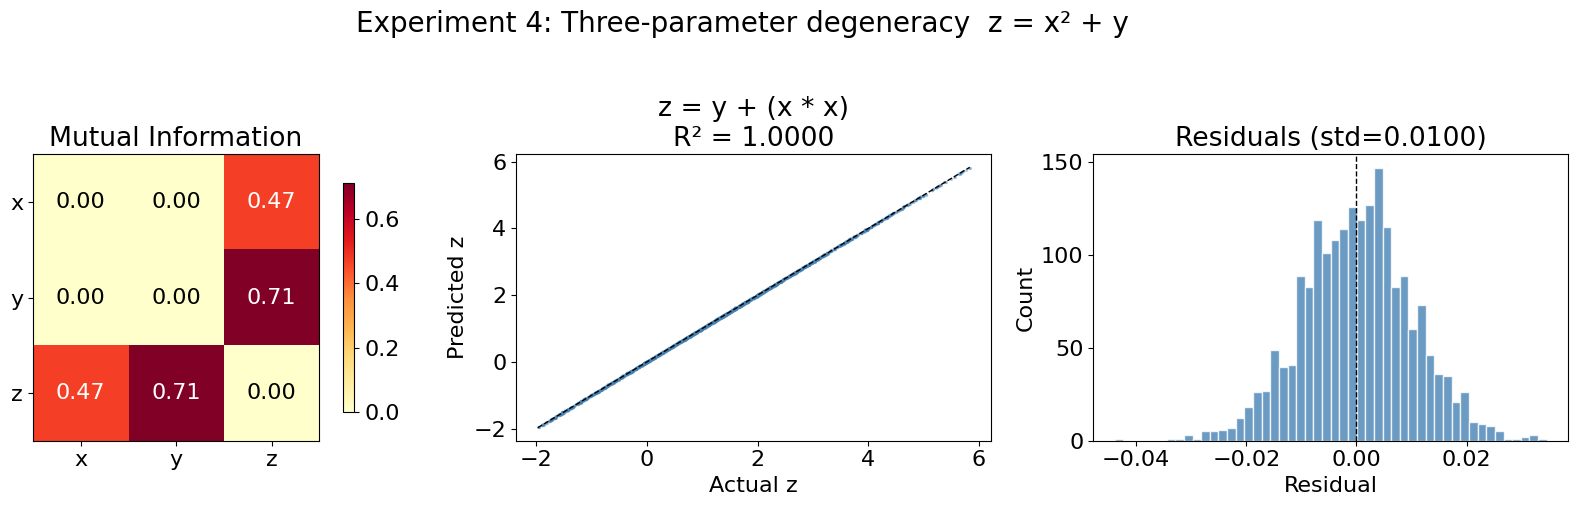

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# MI heatmap
ax = axes[0]
mi = res_4.grouping.mi_result.mi_matrix
im = ax.imshow(mi, cmap='YlOrRd')
ax.set_xticks(range(len(names_4))); ax.set_yticks(range(len(names_4)))
ax.set_xticklabels(names_4); ax.set_yticklabels(names_4)
for i in range(len(names_4)):
    for j in range(len(names_4)):
        ax.text(j, i, f'{mi[i,j]:.2f}', ha='center', va='center',
                color='white' if mi[i,j] > mi.max()/2 else 'black')
plt.colorbar(im, ax=ax, shrink=0.8)
ax.set_title('Mutual Information')

# Predicted vs actual
ax = axes[1]
if res_4.multi_degeneracies:
    fit = res_4.multi_degeneracies[0].fit
    input_idx = [names_4.index(n) for n in fit.input_names]
    target_idx = names_4.index(fit.target_name)
    y_actual = samples_4[:, target_idx]
    y_pred = fit.predict(samples_4[:, input_idx])
    ax.scatter(y_actual, y_pred, s=2, alpha=0.3, c='steelblue')
    lims = [min(y_actual.min(), y_pred.min()), max(y_actual.max(), y_pred.max())]
    ax.plot(lims, lims, 'k--', lw=1)
    ax.set_xlabel(f'Actual {fit.target_name}')
    ax.set_ylabel(f'Predicted {fit.target_name}')
    ax.set_title(f'{fit.equation_str}\nR² = {fit.r_squared:.4f}')

# Residuals
ax = axes[2]
if res_4.multi_degeneracies:
    residuals = y_actual - y_pred
    ax.hist(residuals, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
    ax.axvline(0, color='k', ls='--', lw=1)
    ax.set_xlabel('Residual')
    ax.set_ylabel('Count')
    ax.set_title(f'Residuals (std={np.std(residuals):.4f})')

fig.suptitle('Experiment 4: Three-parameter degeneracy  z = x² + y', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()